## Flurry number 2 - Carlando!

2020 was an amazing year to watch Forumla 1 for the first time. McLaren quickly stood out to me as my favorite team, with their laid back drivers and brilliant social media presence. But while their drivers Carlos Sainz and Lando Norris are good friends on and off track, it's time to see who stood out more this year, despite both of them having fantastic performances this year. We'll take a look at data from qualifying, races, and hopefully (if the F1 API allows it) lap times.

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

All the data for this project will come from Ergast [http://ergast.com/mrd/](http://ergast.com/mrd/), a free API for absolute bucketloads of formula 1 data. While it's not quite updated in real time, it's a fantastic free resource otherwise. To reduce the load on the API (since we would be making quite a few calls to get laptime data), I downloaded the Decmeber 22 2020 image of the Ergast database in CSV form from [http://ergast.com/mrd/db/](http://ergast.com/mrd/db/). All those files have been unzipped into the f1db_csv/ folder. Be sure to check the Ergast site for documentation on the data and its API.

In [2]:
# lets load in a few of the CSVs
drivers = pd.read_csv('f1db_csv/drivers.csv')
print(drivers.dtypes)
drivers.head()

driverId        int64
driverRef      object
number         object
code           object
forename       object
surname        object
dob            object
nationality    object
url            object
dtype: object


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [3]:
races = pd.read_csv('f1db_csv/races.csv').set_index('raceId')
print(races.dtypes)
races.head()

year          int64
round         int64
circuitId     int64
name         object
date         object
time         object
url          object
dtype: object


,year,round,circuitId,name,date,time,url
raceId,,,,,,,
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [4]:
# lets grab both drivers' ID numbers from the drivers table

sainzID = drivers[(drivers['surname']=='Sainz') & (drivers['forename']=='Carlos')] \
    ['driverId'] \
    .iloc[0]

norrisID = drivers[(drivers['surname']=='Norris') & (drivers['forename']=='Lando')] \
    ['driverId'] \
    .iloc[0]

print(sainzID, norrisID)

832 846


In [5]:
# and now the list of race ID's from the 2020 season

raceIDs = races[races['year']==2020].index.tolist()
raceIDs

[1031,
 1032,
 1033,
 1034,
 1035,
 1036,
 1037,
 1038,
 1039,
 1040,
 1041,
 1042,
 1043,
 1044,
 1045,
 1046,
 1047]

Okay. Goal number 1 will be to create a table, each row representing 1 race, with columns for qualifying position and race finish position for both drivers

In [6]:
qualyRaceResults2020 = pd.DataFrame(columns=[
    'raceName', 
    'sainzQualyPosition', 
    'sainzQualyTime',
    'norrisQualyPosition', 
    'norrisQualyTime',
    'sainzRaceResult', 
    'sainzFastestLap',
    'norrisRaceResult',
    'norrisFastestLap'
], index=raceIDs)

In [7]:
qualifying = pd.read_csv('f1db_csv/qualifying.csv')
results = pd.read_csv('f1db_csv/results.csv')

In [8]:
def stopwatchToSeconds(s):
    if (not isinstance(s, str)) or (s.find('.')==-1):
        return float('NaN')
    
    colonIndex = s.find(':')
    minutes = s[0 : colonIndex if colonIndex>=0 else 0]
    
    dotIndex = s.find('.')
    seconds = s[colonIndex+1 : dotIndex]
    
    millis = s[dotIndex+1 : ]
    
    return int(seconds) + int(millis)/1000 + 60*(0 if len(minutes)==0 else int(minutes))

stopwatchToSeconds('1:04.606')

64.606

In [9]:
driverIDs = [sainzID, norrisID]

for raceID in raceIDs:
    raceName = races.loc[raceID, 'name']
    
    thisQualyResultTable = qualifying[(qualifying['raceId']==raceID) & \
                                      (qualifying['driverId'].isin(driverIDs))] \
        .set_index('driverId')
    
    sainzQualyResult = thisQualyResultTable.loc[sainzID, 'position']
    sainzQualyTime = min(
        stopwatchToSeconds(thisQualyResultTable.loc[sainzID, 'q1']),
        stopwatchToSeconds(thisQualyResultTable.loc[sainzID, 'q2']),
        stopwatchToSeconds(thisQualyResultTable.loc[sainzID, 'q3'])
    )
    norrisQualyResult = thisQualyResultTable.loc[norrisID, 'position']
    norrisQualyTime = min(
        stopwatchToSeconds(thisQualyResultTable.loc[norrisID, 'q1']),
        stopwatchToSeconds(thisQualyResultTable.loc[norrisID, 'q2']),
        stopwatchToSeconds(thisQualyResultTable.loc[norrisID, 'q3'])
    )
    
    thisRaceResultTable = results[(results['raceId']==raceID) & \
                                  (results['driverId'].isin(driverIDs))] \
        .set_index('driverId')
    sainzRaceResult = thisRaceResultTable.loc[sainzID, 'positionOrder']
    sainzFastestLap = stopwatchToSeconds(thisRaceResultTable.loc[sainzID, 'fastestLapTime'])
    norrisRaceResult = thisRaceResultTable.loc[norrisID, 'positionOrder']
    norrisFastestLap = stopwatchToSeconds(thisRaceResultTable.loc[norrisID, 'fastestLapTime'])
    
    qualyRaceResults2020.loc[raceID] = pd.Series({
        'raceName': raceName, 
        'sainzQualyPosition': sainzQualyResult, 
        'sainzQualyTime': sainzQualyTime,
        'norrisQualyPosition': norrisQualyResult, 
        'norrisQualyTime': norrisQualyTime,
        'sainzRaceResult': sainzRaceResult, 
        'sainzFastestLap': sainzFastestLap,
        'norrisRaceResult': norrisRaceResult,
        'norrisFastestLap': norrisFastestLap
    })
    
headToHead = qualyRaceResults2020.replace(to_replace=r'\N', value=float('NaN'))
headToHead

,raceName,sainzQualyPosition,sainzQualyTime,norrisQualyPosition,norrisQualyTime,sainzRaceResult,sainzFastestLap,norrisRaceResult,norrisFastestLap
1031,Austrian Grand Prix,8,63.971,4,63.626,5,67.974,3,67.475
1032,Styrian Grand Prix,3,78.590,6,78.448,9,65.619,5,67.193
1033,Hungarian Grand Prix,9,75.027,8,74.966,9,80.477,13,79.945
1034,British Grand Prix,7,85.965,5,85.782,13,89.948,5,90.058
1035,70th Anniversary Grand Prix,13,87.083,10,86.778,13,90.556,9,90.698
1036,Spanish Grand Prix,7,76.876,8,77.084,6,81.771,10,82.392
1037,Belgian Grand Prix,7,102.438,10,102.657,20,NaN,7,108.552
1038,Italian Grand Prix,3,79.695,6,79.820,2,83.882,4,84.232
1039,Tuscan Grand Prix,9,76.522,11,76.640,18,134.103,6,81.198
1040,Russian Grand Prix,6,92.550,8,92.847,19,NaN,15,97.377


Fantastic! Here's qualifying postion and time, race finish postion, and fastest lap time for both drives in every race in 2020. There are a couple NaN's for Carlos Sainz's fastest lap in Belgium (DNS) and Russia (crash on lap 1), so I'll fill those in with Lando's fastest lap from those races.

In [10]:
headToHead['sainzFastestLap'].fillna(value=headToHead['norrisFastestLap'], inplace=True)

Qualifying might be a better indication of true pace than race data, so let's start there.

<AxesSubplot:>

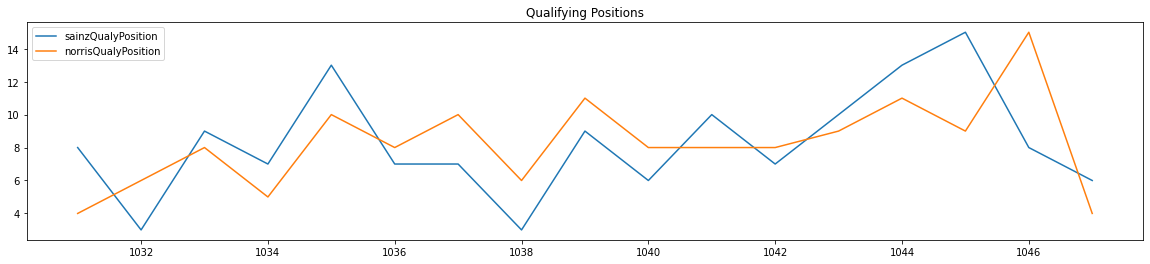

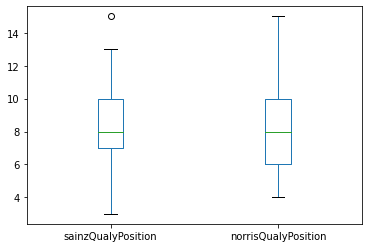

In [11]:
plotsize = (20, 4)

headToHead.plot.line(y=['sainzQualyPosition', 'norrisQualyPosition'], title='Qualifying Positions', figsize=plotsize)
headToHead.plot.box(y=['sainzQualyPosition', 'norrisQualyPosition'])


Looks like a dead heat in qualifying to me. If anything, Norris seems to be able to consistently reach into that 5-6th grid slot more consistently than Carlos. Maybe qualifying lap times will reveal something, but don't get your hopes up.
We'll set Carlos as the benchmark, and plot the percent difference to Lando's laps.

<AxesSubplot:title={'center':'Norris Qualifying times against Sainz benchmark'}>

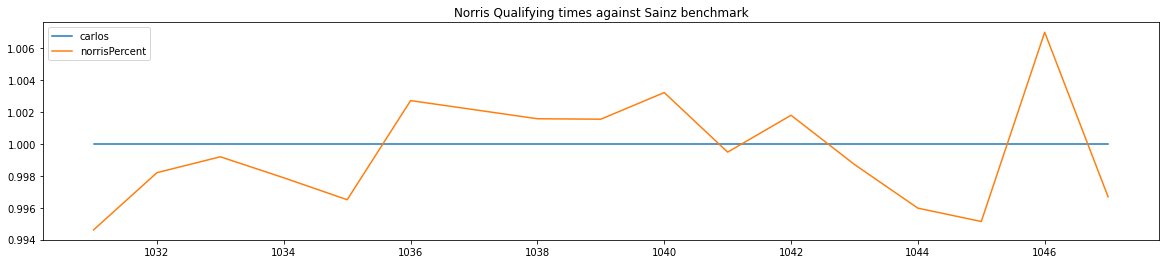

In [12]:
qualifyingTimesHeadToHead = pd.DataFrame(columns=['carlos', 'norrisPercent'])
qualifyingTimesHeadToHead['norrisPercent'] = headToHead['norrisQualyTime'] / headToHead['sainzQualyTime']
qualifyingTimesHeadToHead['carlos'].fillna(value=1, inplace=True)
qualifyingTimesHeadToHead.plot.line(title='Norris Qualifying times against Sainz benchmark', figsize=plotsize)

Still looks damn even. Again, Norris had a few more of those weekends where he could beat Carlos by a "substantial" amount (a couple tenths of a second), but hard to say one outperformed the other when they trade blows in qualifying so often.

In [13]:
fastestRaceLapHeadToHead = pd.DataFrame(columns=['carlos', 'norrisPercent'])
fastestRaceLapHeadToHead['norrisPercent'] = headToHead['norrisFastestLap'] / headToHead['sainzFastestLap']
fastestRaceLapHeadToHead['carlos'].fillna(value=1, inplace=True)
fastestRaceLapHeadToHead.head(1)

,carlos,norrisPercent
1031,1,0.992659


The same graph for fastest lap times in the race shows a blip in race 1039: Mugello, where all the lap times Carlos set before crashing were under safety car (therefore very slow compared to a racing lap). Therefore this plot ignores the Mugello race.

<AxesSubplot:title={'center':'Norris Fastest Lap times against Sainz benchmark'}>

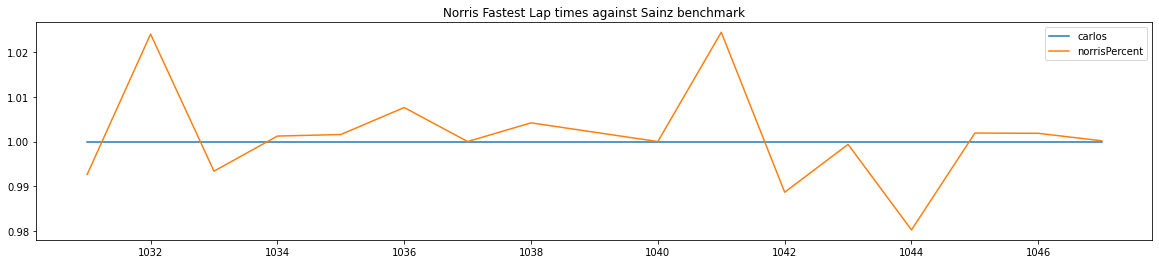

In [14]:
fastestRaceLapHeadToHead.drop(1039, axis='index').plot.line(title='Norris Fastest Lap times against Sainz benchmark', figsize=plotsize)

Interesting. Carlos actually takes the cake here, mostly due to his consistent performance (despite the few massive differences where one of them actually won fastest lap points)

#### Race Analyses

Okay, looking at data from qualifying times and fastest lap times doesn't tell us a whole lot about one of the Mclaren drivers clearly beating out the other. If we had to make a conclusion, Lando Norris seemed to reach into those top qualifying slots more consistently, and Carlos Sainz tended to have a slightly faster racing lap time.

Not we can look into lap-by-lap times from one race at a time. This is the sort of data that would be awesome to display live on a website as live telemetry, showing how the drivers are lapping compared to one another. This data will certainly have some problems.
- It doesn't factor in tire compound or tire wear
- It doesn't reflect being stuck behind another car
- Pit stop laps and safety car laps will be very far off from a standard racing lap
All the same, we can plot the data anyway.

We'll take a look at Monza, where Carlos would have won the race if not for the red flag, and Abu Dhabi, where Mclaren finished 5-6 running most of the race in clean air.

In [15]:
monzaRaceId = 1038
abudhabiRaceId = 1047

lapTimes = pd.read_csv('f1db_csv/lap_times.csv')
lapTimes['seconds'] = lapTimes['milliseconds'] / 1000
lapTimes.head(1)

,raceId,driverId,lap,position,time,milliseconds,seconds
0,841,20,1,1,1:38.109,98109,98.109


In [16]:
monzaLapTimes = lapTimes[(lapTimes['raceId'] == monzaRaceId) & \
                        (lapTimes['driverId'].isin(driverIDs))]

pd.options.mode.chained_assignment = None  # default='warn'
monzaLapTimes['driver'] = monzaLapTimes['driverId'].apply(
    lambda i: 'Sainz' if i==sainzID else 'Norris'
)
monzaLapTimes.set_index('lap', inplace=True)
monzaLapTimes.head(1)

,raceId,driverId,position,time,milliseconds,seconds,driver
lap,,,,,,,
1,1038,832,2,1:27.292,87292,87.292,Sainz


In [17]:
ADLapTimes = lapTimes[(lapTimes['raceId'] == abudhabiRaceId) & \
                        (lapTimes['driverId'].isin(driverIDs))]

pd.options.mode.chained_assignment = None  # default='warn'
ADLapTimes['driver'] = ADLapTimes['driverId'].apply(
    lambda i: 'Sainz' if i==sainzID else 'Norris'
)
ADLapTimes.set_index('lap', inplace=True)

driver
Norris    AxesSubplot(0.125,0.125;0.775x0.755)
Sainz     AxesSubplot(0.125,0.125;0.775x0.755)
Name: seconds, dtype: object

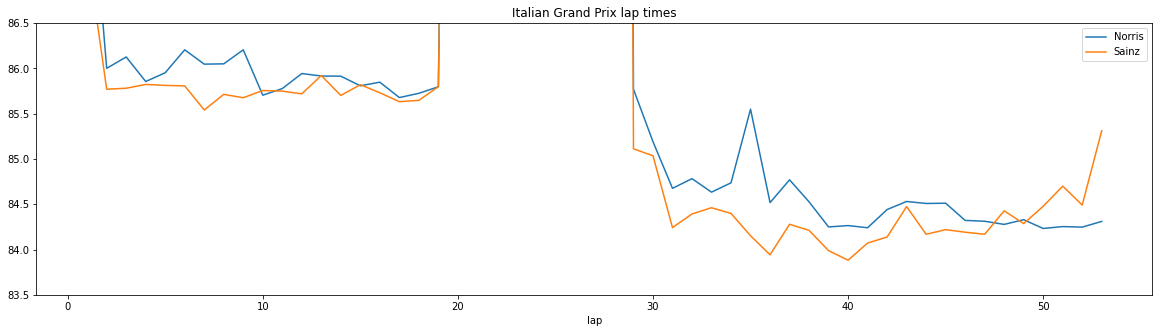

In [18]:
monzaLapTimes.groupby('driver')['seconds'].plot(legend=True, ylim=(83.5, 86.5), figsize=(20, 5), title='Italian Grand Prix lap times')


driver
Norris    AxesSubplot(0.125,0.125;0.775x0.755)
Sainz     AxesSubplot(0.125,0.125;0.775x0.755)
Name: seconds, dtype: object

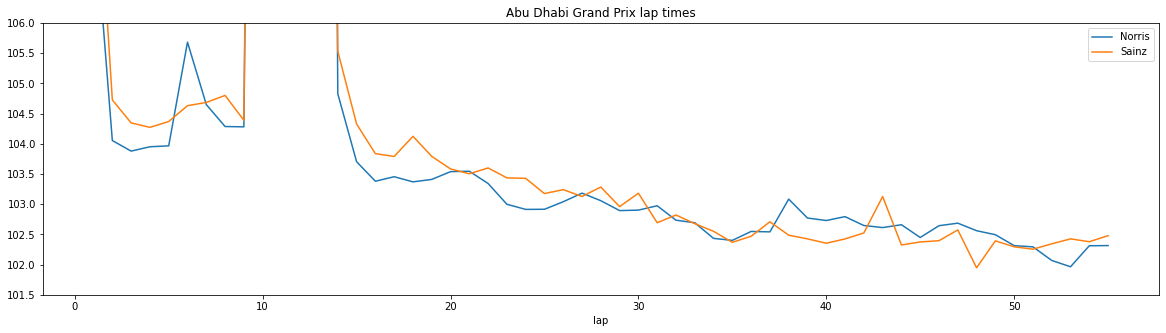

In [19]:
ADLapTimes.groupby('driver')['seconds'].plot(legend=True, ylim=(101.5, 106), figsize=(20, 5), title='Abu Dhabi Grand Prix lap times')

These are actually some pretty fun plots, and they tell good stories.

In Italy, Carlos quickly jumped into 2nd place and was running in clear air (well behind Hamilton), compared to Lando Norris in 3rd stuck in the dirty air behind his teammate. A similar story unfolded after the red flag, as Carlos again got himself quickly into 2nd while Lando had to fight through a few more cars to get up to 4th. Finally, Sainz's uptick in lap times in the final few laps can be explained by his medium tires quickly wearing out as he caught up to race winner Pierre Gasly, but couldn't find the pace to get through.

Abu Dhabi was definitley a snooze-fest for us as fans, but was brilliant for Mclaren. Norris qualified 4th, and after Albon passed him on lap 6, he ran in relatively clean air for the entire race, with Sainz maintaining a consistent 3-6 second gap right behind him. The most interesting takeaway I see in the Abu Dhabi data is that both cars got faster over time on their final stint with the Hard compound tire. This could be attributed to Norris having to follow behind Daniel Ricciardo, who took his first stint (hard tires) to lap 40, but it can't be ignored that Sainz and Norris seem to be doing some serious tire management during the race, with a lot of potential pace left untapped.

Hopefully 2021 will give us an even more exciting season than 2020 did, although that will be hard to do. Mclaren says goodbye to Carlos Sainz and he heads to Ferrari (poor guy deserves better than Ferrari's current pace), and says hello to the all-smiles Daniel Ricciardo. DR and Lando Norris will certainly make for an entertaining driver pairing, but I doubt their relationship will be quite as intimate as the Carlando bromance. It will be interesting to see if Norris's performance might suffer because of that.

Happy New Year everyone! Cheers to ground effect, only 12 months away.